In [20]:
%matplotlib widget
#Comment the line above to switch off interactive plots

import math
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from scipy.stats import multivariate_normal

import tensorflow as tf

#The default size of the graphs
plt.rcParams['figure.figsize'] = [6, 6]

In [21]:
DARTBOARD_DIAMETER_MM = 340 #millimeters

def calculate_score(arrowx: int, arrowy: int) -> int:
    """Calculates the score of a throw given X and Y coordinates
    Args:
        arrowx:
            the X coordinate of a throw
        arrowy:
            the Y coordinate of a throw

    Returns:
        The score of a throw
    """
    score = 0
    distance = 0

    #Pythagoras formula to calculate the distance to the centre.
    distance = math.sqrt(arrowx**2 + arrowy**2)
    if distance < 5.37:
        return 50

    if distance < 8.09:
        return 25

    if distance > 144:
        return 0

    multiplier = 1

    if 82.5 <= distance < 91:
        multiplier = 3
    elif 135.59 <= distance <= 144:
        multiplier = 2

    #Use SOHCAHTOA to calculate the angle matching the arrow position
    arctng = math.atan2(arrowy,arrowx)
    angle = math.degrees(arctng)
    angle = min(angle+9,360) # Add 9' to "rotate" the sectors to simplify the calculation
    if angle<0:
        angle+=360

    #The scores of the sectors
    scrs = [6, 13, 4, 18, 1, 20, 5, 12, 9, 14, 11, 8, 16, 7, 19, 3, 17, 2, 15, 10]
    sector_score = scrs[int(angle//18)] # 18' is the angle of a sector
    score = multiplier * sector_score

    return score

def vectorize_score(elid: int) -> int:
    """Transforms the id of a possible throw to x, y coordinates
    and calculates the score of the dartboard

    Args:
        elid:
            the id of a grid cell, range elid 0-90000 

    Returns:
        Score of grid cell
    """
    x_coordinate = elid - (elid//300)*300 - 150
    y_coordinate = 150 - (elid // 300)

    return calculate_score(x_coordinate, y_coordinate)

vfunc = np.vectorize(vectorize_score, otypes=[np.intc]) #To speed up the calculations


def calculate_pdf(distr_mean, sigma: int, x_ax_grid: np.array, y_ax_grid: np.array):
    """PDF - Probability density function
    Args:
        distr_mean:
            mean of the distribution, numpy array
        sigma:
            standard deviation of a throw in mm
        x_ax_grid:
            X axis grid, numpy array
        y_ax_grid:
            Y axis grid, numpy array

    Returns:
        The probability distribution
    """
    # Pack X and Y into a single 3-dimensional array
    pos = np.dstack((x_ax_grid, y_ax_grid))

    mlt_var = multivariate_normal(distr_mean, sigma**2)
    return mlt_var.pdf(pos)


def calculate_optimal_point(sigma_px: int, x_ax_grid: np.array,
                             y_ax_grid: np.array, conv_placeholder: tf.Tensor):
    """Calculates the point to maximize the score of a throw given standard deviation of throws
    Args:
        sigma_px:
            the standard deviation of a throw in units of a grid
        x_ax_grid:
            the X axis grid
        y_ax_grid:
            the Y axis grid
        conv_placeholder:
            the tensorflow constant
    
    Returns:
        max_bucket:
            the coordinates of a a throw to maximize the score
        conv:
            the expected values of a throw
        pr_dens_func/pr_dens_func.sum():
            the distribution for a given throw
        sigma_in_mm:
            sigma in millim.
    """

    #Convert sigma to mm
    sigma_in_mm = int(DARTBOARD_DIAMETER_MM/288*sigma_px)
    mean_dstr = np.array([0., 0])

    pr_dens_func = calculate_pdf(mean_dstr, sigma_in_mm, x_ax_grid, y_ax_grid)
    pr_dens_func = np.reshape(pr_dens_func,\
                               (pr_dens_func.shape[0], pr_dens_func.shape[0], 1, 1))

    #Calculates the Expected values for every point on the dartboard
    kernel = tf.constant(pr_dens_func, dtype=tf.float32)
    x_grid_shape = x_ax_grid.shape
    conv_arr = tf.nn.conv2d(conv_placeholder, kernel, strides=1, \
                        padding=[[0, 0], [x_grid_shape[0]/2, x_grid_shape[0]/2-1],\
                                  [x_grid_shape[0]/2, x_grid_shape[0]/2-1], [0, 0]])

    conv_arr = np.squeeze(conv_arr)
    pr_dens_func = np.squeeze(pr_dens_func)

    max_bucket = np.unravel_index(conv_arr.argmax(), conv_arr.shape)

    #sum of pr_dens_func is not exactly 1.0, so normalize
    return max_bucket, conv_arr, pr_dens_func/pr_dens_func.sum(), sigma_in_mm

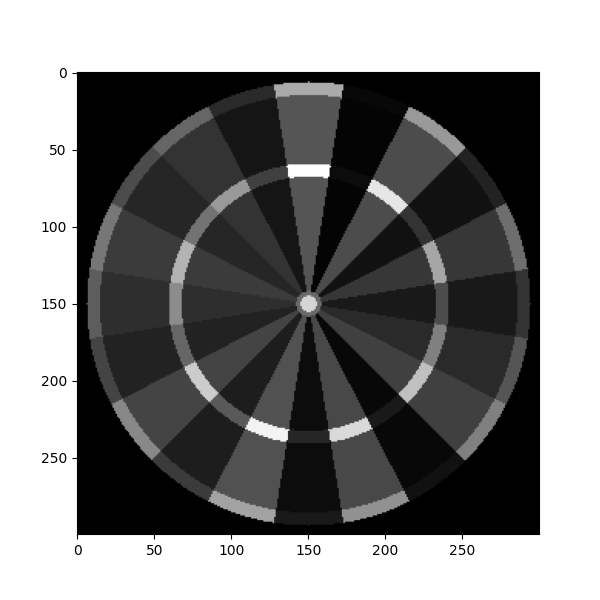

In [22]:
#2D environment, -150 to 150 with the step of 1
#BULL (center of the dartboard) coordinates: (0, 0)
N = 300
x_axis_grid = np.linspace(-150, 150, N)
y_axis_grid = np.linspace(-150, 150, N)
x_axis_grid, y_axis_grid = np.meshgrid(x_axis_grid, y_axis_grid)

#Create a dartboard
score_array = np.arange(0, x_axis_grid.shape[0]**2)
darts_score_map = vfunc(score_array)
darts_score_map = np.reshape(darts_score_map, (x_axis_grid.shape[0], x_axis_grid.shape[1], 1))

darts_score_map = darts_score_map[np.newaxis,:]
darts_score_map = darts_score_map.astype(int)

convolution_placeholder = tf.constant(darts_score_map, dtype=tf.float32)
darts_score_map = np.squeeze(darts_score_map)

#Uncomment to display the dartboard
fig = plt.figure()
plt.imshow(np.squeeze(darts_score_map), cmap="gray")
plt.show()

In [23]:
observations = []

for sigmaPX in range(5,10,5):
    max_point, conv, pdf, sigma_mm  = \
        calculate_optimal_point(sigmaPX, x_axis_grid, y_axis_grid, convolution_placeholder)

    print(f'Sigma {sigma_mm}mm, point {max_point}\
           ({np.argmax(conv)}), Expected score {np.amax(conv):.2f}, \
          max point value {darts_score_map[max_point[0], max_point[1]]}')

    #List to hold the optimal throw targets
    observations.append([sigmaPX, max_point, np.amax(conv), pdf, sigma_mm])


Sigma 5mm, point (64, 150)           (19350), Expected score 42.72,           max point value 60


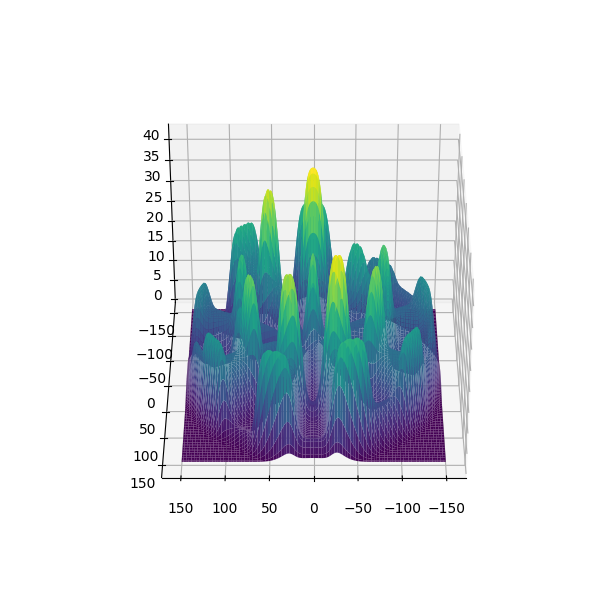

In [24]:

#Display the 3D graphs
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(x_axis_grid, y_axis_grid, conv, \
                rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)
ax.view_init(35, 90)
plt.show()


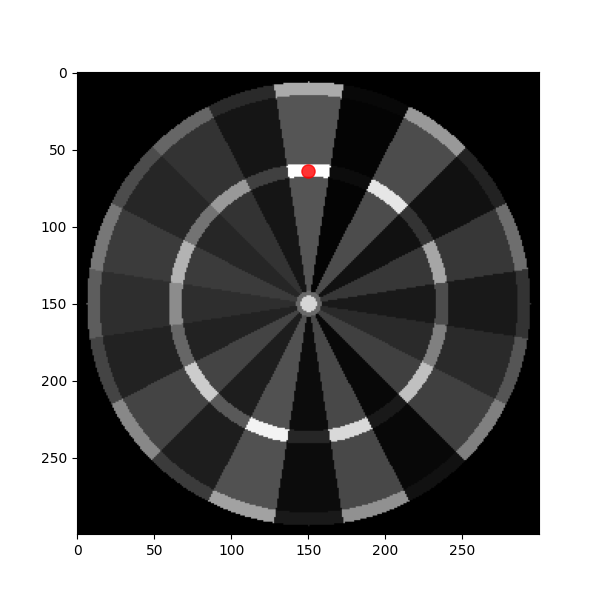

In [25]:
#Display the optimal throw targets on a 2D board
x_coordinates = [p[1][1] for p in observations] #X coordinate on the grid (not mm)
y_coordinates = [p[1][0] for p in observations] #Y coordinates on the grid (not mm)
fig = plt.figure()
plt.imshow(darts_score_map, cmap="gray")
plt.scatter(x_coordinates, y_coordinates, s=90, c='red', marker='o', alpha=0.8)
plt.show()

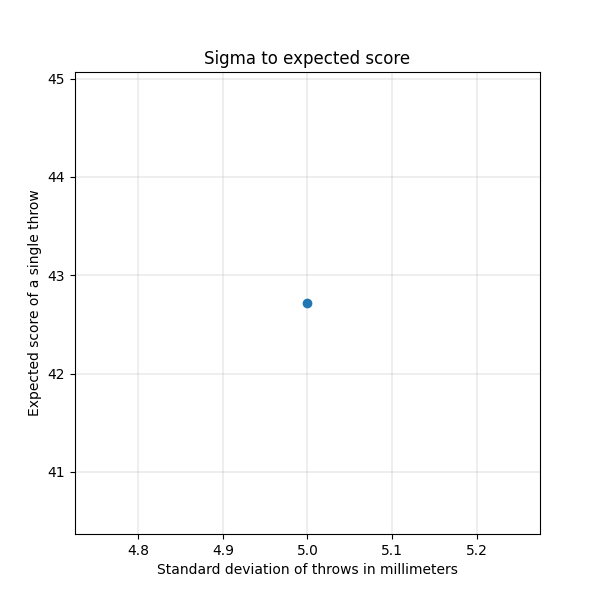

In [26]:
#Plot the graph expected score of a throw depending of standard deviation of throws

sigmaVals = [p[4] for p in observations]
scoreVals = [p[2] for p in observations]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sigmaVals, scoreVals, marker='o')
ax.grid(True, linewidth=0.3)

ax.set_title("Sigma to expected score")
ax.set_ylabel("Expected score of a single throw")
ax.set_xlabel("Standard deviation of throws in millimeters")

plt.show()